In [ ]:
__author__ = "Matteo Pariset"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os

In [2]:
import jax
import jax.numpy as jnp
import ott

import os

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rcParams["figure.figsize"] = (6.4, 4.8)

plt.rcParams['font.family'] = 'serif'
sns.set_context(context='talk', font_scale=.9)
palette = ['#1A254B', '#114083', '#A7BED3', '#F2545B', '#A4243B']

cmap = LinearSegmentedColormap.from_list('cmap', palette, N=18)

colors = ['#1A254B', '#114083', '#A7BED3', '#FFFFFF', '#F2545B', '#A4243B']
from matplotlib.colors import LinearSegmentedColormap
bcmap = LinearSegmentedColormap.from_list('bcmap', colors, N=100)


def plot_marginal(marginal, dim_reduction, **kwargs):
    plt.scatter(*dim_reduction(marginal).T, **kwargs)
    plt.axis("equal")
    
def plot_marginals(t0_marginal, t1_marginal, t0_color=cmap(.2), t1_color=cmap(.8), projection=lambda x: x, **kwargs):
    if 'alpha' not in kwargs:
        kwargs['alpha'] = .4
    plt.scatter(*projection(t0_marginal).T, color=t0_color, label=r"$t_0$", **kwargs)
    plt.scatter(*projection(t1_marginal).T, color=t1_color, label=r"$t_1$", **kwargs)
    plt.axis("equal")
    plt.legend();

def plot_multiple_marginals(marginals, statuses, dim_reduction, step_nums, normalize=False, labels=None, s=.5):
    if normalize:
        marginals = norm_step(marginals)
    for i, step in enumerate(step_nums):
        if isinstance(labels, bool) and not labels:
            label = None
        elif labels is not None and len(labels) > 2:
            label = labels[i]
        elif labels is not None and len(labels) == 2:
            if step == step_nums[0]:
                label = labels[0]
            elif step == step_nums[-1]:
                label = labels[1]
            else:
                label = None
        else:
            label = None
        plot_marginal(marginals[i,statuses[i]], dim_reduction, s=s, color=cmap(i/float(marginals.shape[0]-1)), label=label)
    plt.legend()

def plot_matchings(t0_points, t1_points, projection=lambda x: x, **kwargs):
    kwargs["color"] = kwargs.get("color", "gray")
    kwargs["alpha"] = kwargs.get("alpha", .7)
    kwargs["lw"] = kwargs.get("lw", .2)
    extended_coords = np.concatenate([projection(t0_points), projection(t1_points)], axis=1)
    plt.plot(extended_coords[:,::2].T, extended_coords[:,1::2].T, zorder=0, **kwargs);

def plot_predictions(preds, projection=lambda x: x):
    plt.scatter(*projection(preds[-1]).T, s=7.5, zorder=1, edgecolors="black", facecolors="black", label="predictions")


def draw_particle_paths(viewer, trajs=None):
    if trajs is None:
        trajs, _, statuses = viewer.get_fresh_trajectories(FORWARD)

    fig, ax = plt.subplots()

    selected_trajs = random.choice(viewer.key, trajs.shape[1], (5,))

    fig.set_size_inches(26, 15)
    plts = [
        ax.plot(*jnp.einsum("ijk->kij", trajs), color="grey", lw=.09)[0],
        ax.plot(*jnp.einsum("ijk->kij", trajs[:,selected_trajs]), color="black", lw=1)[0]
    ]

def export_fig(fig_name, force=True, extension="svg"):
    fig_path = f"../figures/{fig_name}.{extension}"
    if not os.path.exists(fig_path) or force:
        plt.savefig(fig_path, bbox_inches="tight", transparent=True)

def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()

def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))


def square_norm(vec):
    return np.square(vec).sum(axis=-1)

def compute_rmsd(target, predicted):
    return np.sqrt(square_norm(target-predicted).mean(axis=0))

def compute_norm_rmsd(target, predicted):
    return compute_rmsd(target, predicted) / (np.sqrt(square_norm(target).max()) - np.sqrt(square_norm(target).min()))

# def compute_l2_difference(target, predicted):
#     return np.sqrt(square_norm(target-predicted)).mean(axis=0)

def compute_l2_difference(target, predicted):
    return np.sqrt(square_norm(target.mean(axis=0) - predicted.mean(axis=0)))


def make_geometry(t0_points, t1_points):
    """ Set up inital/final cloud points living in space endowed with squared Eucliden distance
    """
    point_cloud = ott.geometry.pointcloud.PointCloud(t0_points, t1_points, ott.geometry.costs.SqEuclidean())
    return point_cloud
def compute_ot(t0_points, t1_points):
    """ Solve OT problem
    """
    point_cloud = make_geometry(t0_points, t1_points)
    sinkhorn = ott.solvers.linear.sinkhorn.Sinkhorn()(ott.problems.linear.linear_problem.LinearProblem(point_cloud))
    return sinkhorn
def transport(ot, init_points):
    return ot.to_dual_potentials().transport(init_points)
def compute_wasserstein_2(preds, true):
    ot = compute_ot(preds, true)
    return jnp.sqrt(ot.transport_cost_at_geom(make_geometry(preds, true))).item()

def compute_metrics(target, predicted):
    return {
        'mmd': compute_scalar_mmd(target, predicted),
        'norm_rmsd': compute_norm_rmsd(target, predicted).item(),
        'l2': compute_l2_difference(target, predicted).item(),
        'w2': compute_wasserstein_2(target, predicted),
    }


def draw_trajs_with_killing(experiment, **kwargs):
    viewer = Viewer(random.PRNGKey(0), experiment)
    sampled_trajs = [viewer.get_fresh_trajectories(FORWARD) for _ in range(4)]
    trajs, statuses = jnp.concatenate([x[0] for x in sampled_trajs], axis=1), jnp.concatenate([x[2] for x in sampled_trajs], axis=1)

    plot_marginals(
        experiment.start_marginals_sampler[FORWARD](viewer.key)[:300],
        experiment.start_marginals_sampler[BACKWARD](viewer.key)[:300],
        projection=experiment.e.project)
    plot_multiple_marginals(trajs[::12], statuses[::12], experiment.e.project, range(0, 100, 12), labels=False, **kwargs)
    draw_patches(load_patches(experiment.e.killing_function_name), time=None, fig_handle=(plt.gcf(), plt.gca()));

    # Identify deaths
    death_frame = jnp.cumsum(1-statuses, axis=0) == 1
    death_frame = death_frame.at[0].set(False)
    for f_num, d_mask in enumerate(death_frame):
        plot_marginal(trajs.at[f_num, d_mask].get(), dim_reduction=experiment.e.project, s=1., color="black", zorder=10)

    # Identify births
    birth_frame = (jnp.cumsum(1-statuses[::-1], axis=0) == 1)[::-1]
    birth_frame = birth_frame.at[-1].set(False)
    for f_num, b_mask in enumerate(birth_frame):
        plot_marginal(trajs.at[f_num, b_mask].get(), dim_reduction=experiment.e.project, s=5., marker="P", color="white", edgecolors="black", linewidths=.3, zorder=10)


    runs = []
    for _ in range(3):
        sampled_trajs = [viewer.get_fresh_trajectories(FORWARD) for _ in range(4)]
        trajs, statuses = jnp.concatenate([x[0] for x in sampled_trajs], axis=1), jnp.concatenate([x[2] for x in sampled_trajs], axis=1)
        samples_num = min(400, statuses[-1].sum())
        runs.append(compute_metrics(viewer.get_fresh_marginal(BACKWARD)[:samples_num], trajs.at[-1, statuses[-1]].get()[:samples_num]))
    
    print(pd.DataFrame(runs).mean())

    plt.axis("off")

# Prepare Covid spread dataset

In [3]:
variants_of_interest = ["Alpha", "Beta", "Delta", "Gamma", "others"]

## Antigen embeddings

In [4]:
antigen_names = os.listdir("covid/antigens/")
raw_antigen_embs = {name.split("_")[2].capitalize(): np.load(f"covid/antigens/{name}")['arr_0'] for name in antigen_names}
del raw_antigen_embs['Esm-2']

# Add representation of generic variant
raw_antigen_embs['others'] = np.concatenate([raw_antigen_embs[v_name] for v_name in np.setdiff1d(list(raw_antigen_embs.keys()), variants_of_interest)], axis=0).mean(axis=0, keepdims=True)

raw_antigen_embs

{'Eta': array([[[ 0.01364282,  0.03094609,  0.0117565 , ..., -0.22710314,
           0.19633047, -0.04547295],
         [-0.12932709, -0.01227657, -0.03481107, ..., -0.0470578 ,
          -0.05601828, -0.03941881],
         [ 0.02495417,  0.04720129,  0.01540082, ..., -0.08846067,
          -0.02654269, -0.06394067],
         ...,
         [ 0.02772848,  0.00482106,  0.03996927, ..., -0.08242776,
          -0.05614039,  0.04298349],
         [-0.00249537,  0.03341211,  0.01552223, ...,  0.04728384,
           0.01450364,  0.24608165],
         [ 0.04622646,  0.0343352 ,  0.09377613, ..., -0.1528078 ,
           0.18124473, -0.04601015]]], dtype=float32),
 'Delta': array([[[ 1.62143838e-02,  3.54168825e-02,  1.69608630e-02, ...,
          -2.30170310e-01,  1.94863230e-01, -3.77110206e-02],
         [-1.21007904e-01, -2.50083074e-04, -4.87738997e-02, ...,
          -5.43588325e-02, -6.50728121e-02, -3.82247716e-02],
         [ 1.67093948e-02,  5.45542017e-02,  2.52801813e-02, ...,
      

In [5]:
antigen_pca = PCA(4)
antigen_pca.fit(np.concatenate(list(raw_antigen_embs.values()), axis=0).sum(axis=1))
antigen_pca.explained_variance_ratio_

array([0.63277316, 0.21156904, 0.08298278, 0.03291566], dtype=float32)

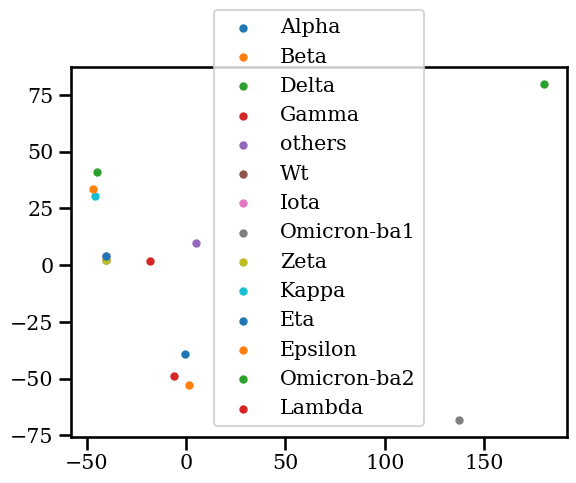

In [6]:
for var_name, var_emb in {k: raw_antigen_embs[k] for k in variants_of_interest + list(set(raw_antigen_embs.keys()).difference(variants_of_interest))}.items():
    plt.scatter(*antigen_pca.transform(var_emb.sum(axis=1)).T[:2], marker="X" if var_name == "wt" else ".", label=var_name)
plt.legend();

export_fig("usb_covid_all_variants_embs")

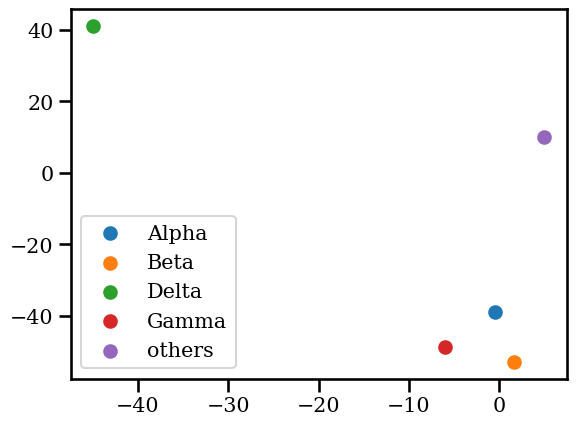

In [7]:
for var_name, var_emb in {k: raw_antigen_embs[k] for k in variants_of_interest}.items():
    plt.scatter(*antigen_pca.transform(var_emb.sum(axis=1)).T[:2], color="gray" if var_name not in variants_of_interest else None, label=var_name)
plt.legend();

export_fig("usb_covid_selected_variants_embs")

In [ ]:
for var_name, var_emb in {k: raw_antigen_embs[k] for k in variants_of_interest}.items():
    plt.scatter(*antigen_pca.transform(var_emb.sum(axis=1)).T[:2], color="gray" if var_name not in variants_of_interest else None, label=var_name)

for var_name, var_emb in {k: raw_antigen_embs[k] for k in list(set(raw_antigen_embs.keys()).difference(variants_of_interest))}.items():
    plt.scatter(*antigen_pca.transform(var_emb.sum(axis=1)).T[:2], marker="X" if var_name == "wt" else ".", color="gray", label=var_name)

plt.legend()

export_fig("usb_covid_highlighted_variants_embs")

In [12]:
raw_variants_antigen_embs = {var_name: antigen_pca.transform(raw_antigen_embs[var_name].sum(axis=1)) for var_name in variants_of_interest}

antigen_scaler = StandardScaler()
antigen_scaler.fit(np.concatenate(list(raw_variants_antigen_embs.values()), axis=0))

raw_variants_antigen_embs = dict(map(lambda var_name: (var_name, antigen_scaler.transform(raw_variants_antigen_embs[var_name])), raw_variants_antigen_embs))

## Variant prevalence

### Dataset source
Taken from <https://www.kaggle.com/datasets/gpreda/covid19-variants>

In [10]:
raw_cov_variants = pd.read_csv("covid/covid-variants.csv")

In [11]:
raw_cov_variants

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
0,Angola,2020-07-06,Alpha,0,0.0,3
1,Angola,2020-07-06,B.1.1.277,0,0.0,3
2,Angola,2020-07-06,B.1.1.302,0,0.0,3
3,Angola,2020-07-06,B.1.1.519,0,0.0,3
4,Angola,2020-07-06,B.1.160,0,0.0,3
...,...,...,...,...,...,...
100411,Zimbabwe,2021-11-01,Omicron,0,0.0,6
100412,Zimbabwe,2021-11-01,S:677H.Robin1,0,0.0,6
100413,Zimbabwe,2021-11-01,S:677P.Pelican,0,0.0,6
100414,Zimbabwe,2021-11-01,others,0,0.0,6


In [12]:
# Remove non_who variant type, since it's redundant (in perc_sequences computation)
cov_variants = raw_cov_variants.query("variant not in ['non_who']")

In [13]:
# Sanity check
# The total number of screened sequences per country per day should be consistent (across all variants)
assert cov_variants.groupby(['location', 'date']).agg(list)['num_sequences_total'].apply(lambda x: len(np.unique(x)) == 1).all()

<Axes: xlabel='date'>

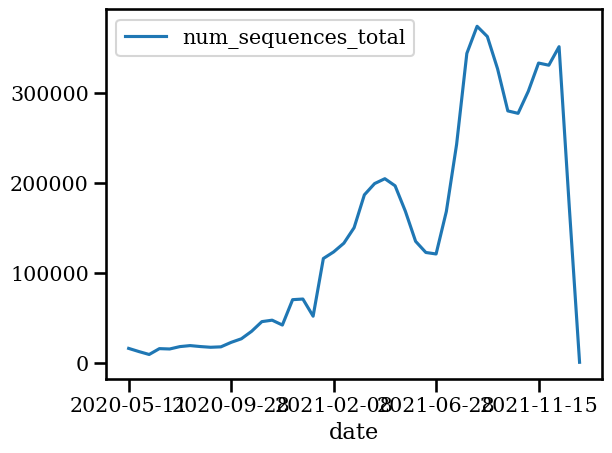

In [14]:
cov_variants.groupby(['date', 'location']).agg({'num_sequences_total': 'first'}).groupby('date').agg({'num_sequences_total': 'sum'}).plot()

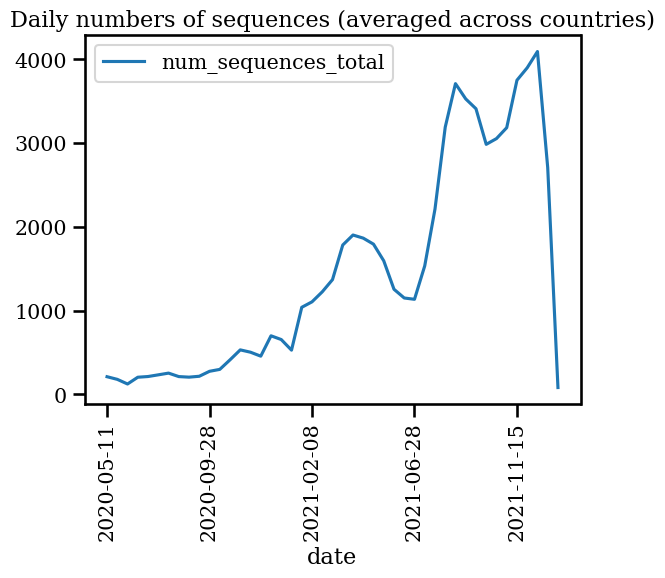

In [15]:
cov_variants.groupby(['date', 'location']).agg({'num_sequences_total': 'first'}).groupby('date').agg({'num_sequences_total': 'mean'}).plot()
plt.title("Daily numbers of sequences (averaged across countries)");
plt.xticks(rotation=90);

<Axes: xlabel='date'>

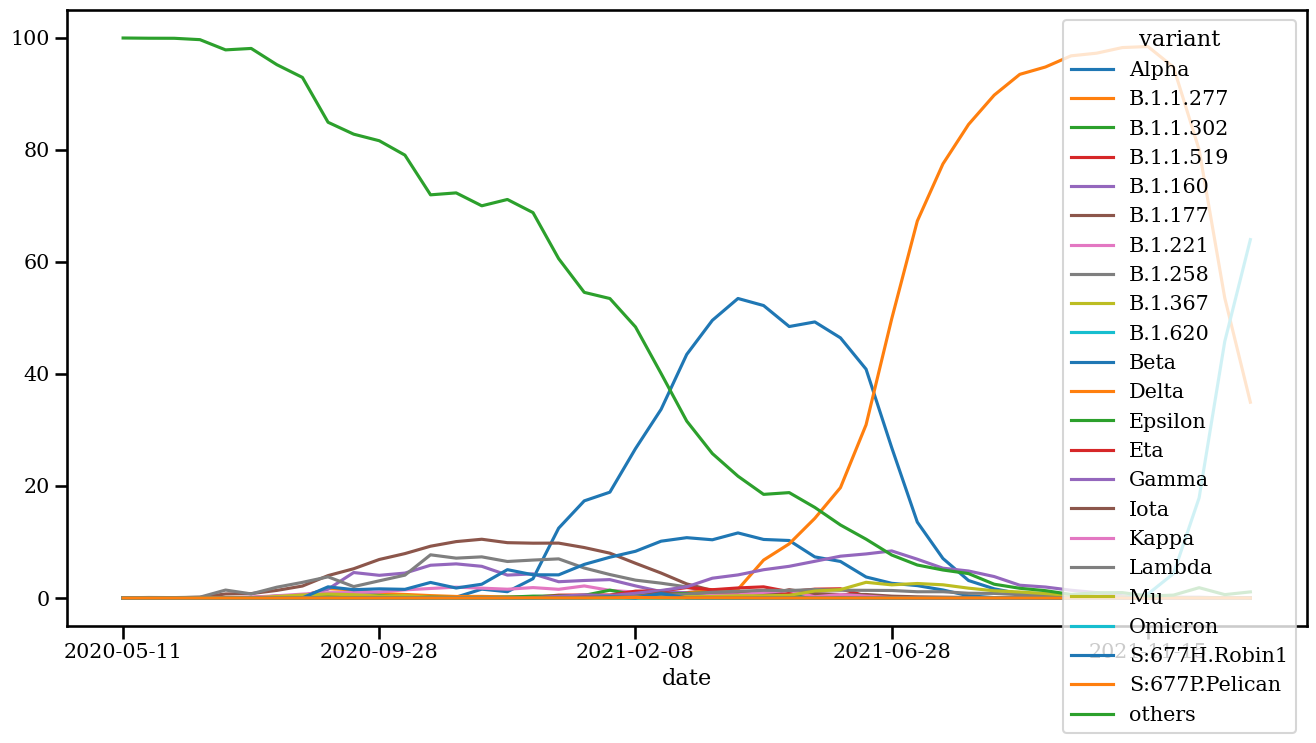

In [16]:
cov_variants.groupby(['date', 'variant']).agg({'perc_sequences': 'mean'}).unstack(1).droplevel(0, axis=1).plot(figsize=(16, 8))

In [17]:
start_date, end_date = pd.to_datetime("2021-01-01"), pd.to_datetime("2021-12-31")
# start_date, end_date = pd.to_datetime("2020-06-01"), pd.to_datetime("2021-12-31")
((start_date <= pd.to_datetime(cov_variants['date'])) * (pd.to_datetime(cov_variants['date']) <= end_date)).mean()

0.655114722753346

In [18]:
period_cov_variants = cov_variants.copy()
period_cov_variants['date'] = pd.to_datetime(cov_variants['date'])
period_cov_variants = period_cov_variants.query("@start_date <= date and date <= @end_date")
period_cov_variants

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
168,Angola,2021-01-04,Alpha,0,0.0,5
169,Angola,2021-01-04,B.1.1.277,0,0.0,5
170,Angola,2021-01-04,B.1.1.302,0,0.0,5
171,Angola,2021-01-04,B.1.1.519,0,0.0,5
172,Angola,2021-01-04,B.1.160,0,0.0,5
...,...,...,...,...,...,...
100410,Zimbabwe,2021-11-01,Mu,0,0.0,6
100411,Zimbabwe,2021-11-01,Omicron,0,0.0,6
100412,Zimbabwe,2021-11-01,S:677H.Robin1,0,0.0,6
100413,Zimbabwe,2021-11-01,S:677P.Pelican,0,0.0,6


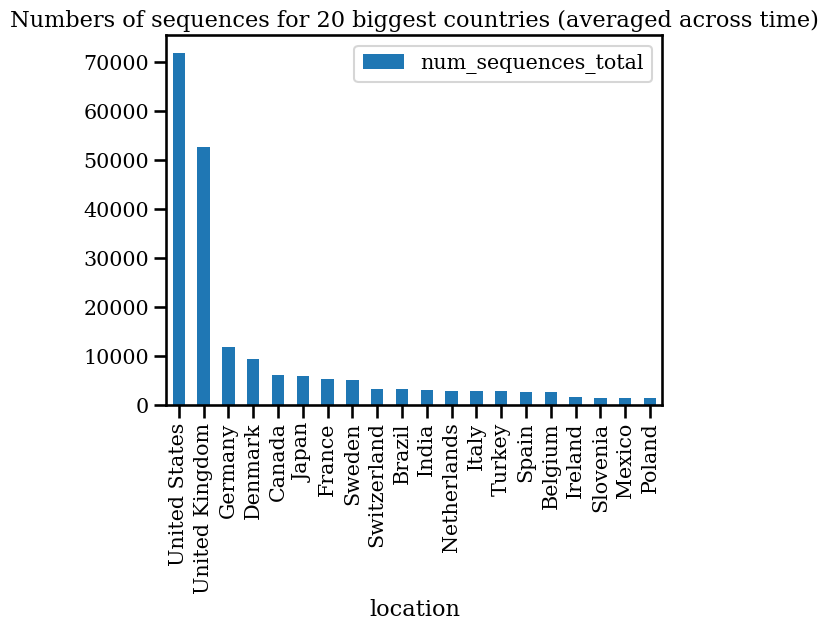

In [19]:
period_cov_variants.groupby(['date', 'location']).agg({'num_sequences_total': 'first'}).groupby('location').agg({'num_sequences_total': 'mean'}).sort_values(by='num_sequences_total', ascending=False)[:20].plot.bar()
plt.title("Numbers of sequences for 20 biggest countries (averaged across time)");

<Axes: xlabel='date'>

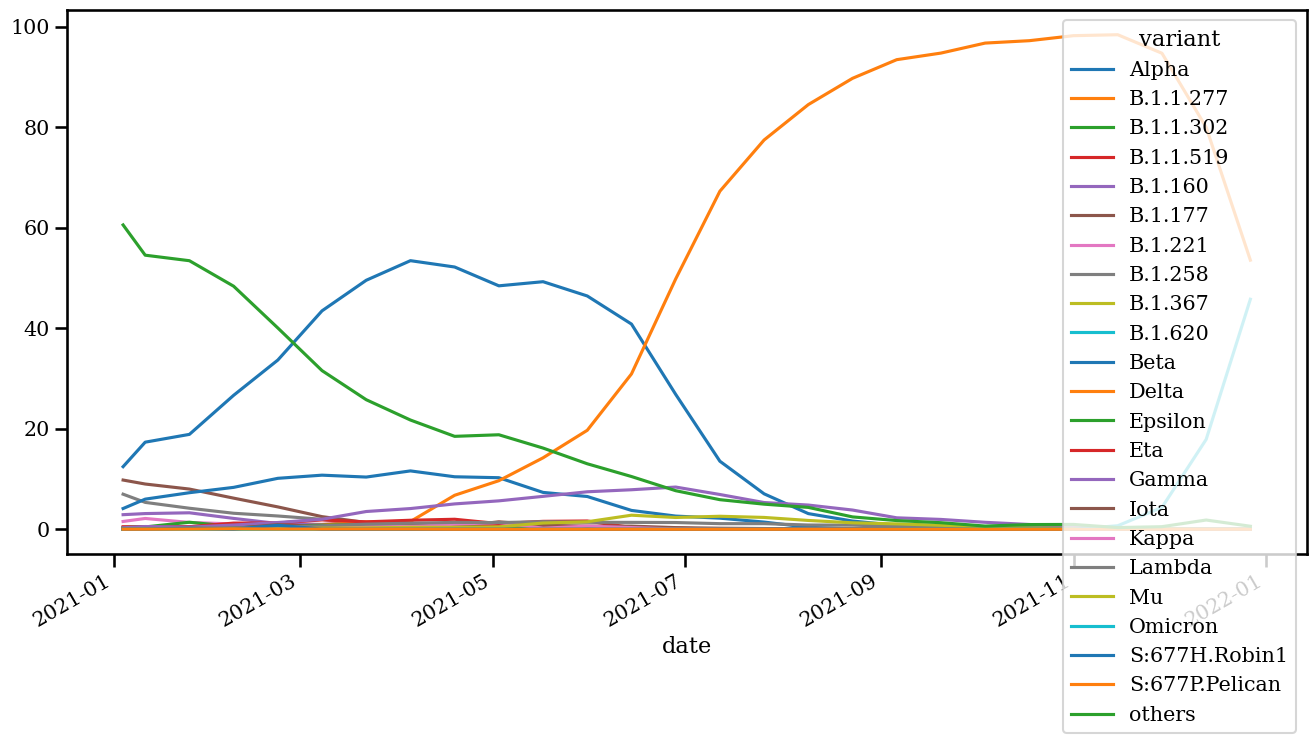

In [20]:
variants_evo = period_cov_variants.groupby(['date', 'variant']).agg({'perc_sequences': 'mean'}).unstack(1).droplevel(0, axis=1)
variants_evo.plot(figsize=(16, 8))

In [21]:
variants_evo.index

DatetimeIndex(['2021-01-04', '2021-01-11', '2021-01-25', '2021-02-08',
               '2021-02-22', '2021-03-08', '2021-03-22', '2021-04-05',
               '2021-04-19', '2021-05-03', '2021-05-17', '2021-05-31',
               '2021-06-14', '2021-06-28', '2021-07-12', '2021-07-26',
               '2021-08-09', '2021-08-23', '2021-09-06', '2021-09-20',
               '2021-10-04', '2021-10-18', '2021-11-01', '2021-11-15',
               '2021-11-29', '2021-12-13', '2021-12-27'],
              dtype='datetime64[ns]', name='date', freq=None)

In [22]:
variants_evo.index[1:] - variants_evo.index[:-1]

TimedeltaIndex([ '7 days', '14 days', '14 days', '14 days', '14 days',
                '14 days', '14 days', '14 days', '14 days', '14 days',
                '14 days', '14 days', '14 days', '14 days', '14 days',
                '14 days', '14 days', '14 days', '14 days', '14 days',
                '14 days', '14 days', '14 days', '14 days', '14 days',
                '14 days'],
               dtype='timedelta64[ns]', name='date', freq=None)

### Extract marginals

In [60]:
t0 = pd.to_datetime("2021-04-05")
t1 = pd.to_datetime("2021-08-09")

In [ ]:
variants_evo.plot(figsize=(16, 8))
plt.vlines(t0, 0, 100, linestyles="dashed", color="grey")
plt.vlines(t1, 0, 100, linestyles="dashed", color="grey")

In [62]:
def to_bulk(df, date, variants_of_interest):
    return df.query("date == @date and variant in @variants_of_interest")

In [63]:
bulk_t0 = to_bulk(period_cov_variants, t0, variants_of_interest)
bulk_t1 = to_bulk(period_cov_variants, t1, variants_of_interest)

In [64]:
def to_fingerprint(bulk):
    percs = bulk.groupby(["location", "variant"]).agg({"perc_sequences": "first"}).unstack(1).droplevel(0, axis=1)
    percs["others"] = percs["others"] + (100 - percs.sum(axis=1))
    percs = percs / 100
    return percs

In [65]:
fingerprint_0 = to_fingerprint(bulk_t0)
fingerprint_0

variant,Alpha,Beta,Delta,Gamma,others
location,,,,,
Angola,0.2336,0.4672,0.0000,0.0073,0.2919
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
Aruba,0.8043,0.0000,0.0000,0.0000,0.1957
Australia,0.5447,0.0732,0.0244,0.0163,0.3414
Austria,0.9278,0.0137,0.0000,0.0000,0.0585
...,...,...,...,...,...
Ukraine,0.5000,0.0000,0.0000,0.0000,0.5000
United Kingdom,0.9819,0.0045,0.0010,0.0005,0.0121
United States,0.5185,0.0075,0.0006,0.0302,0.4432


In [66]:
country_embs = np.load("flights/country_distance_embeddings_59.npz", allow_pickle=True)
country_embs = pd.DataFrame(country_embs['embeddings'], index=country_embs['countries'], columns=["x0", "x1"])
country_embs -= country_embs.mean(axis=0)
country_embs += np.sign(country_embs) * .1 * np.sqrt(np.abs(country_embs))
country_embs

,x0,x1
Afghanistan,-2.145005,0.613341
Albania,-0.838563,2.165687
Algeria,1.400871,0.591206
American Samoa,1.850906,-1.616363
Angola,0.661675,0.797804
...,...,...
Wallis and Futuna,-0.515290,-0.876679
Western Sahara,0.836094,0.298371
Yemen,-2.023602,1.358396
Zambia,-2.144717,1.494673


In [67]:
def to_marginal(fingerprint, abs_counts, country_emb):
    # Compose full state vectors
    full_vectors = country_emb.join(fingerprint, how="inner").join(abs_counts, how="inner")
    
    # Retain only countries with enough measures
    relevant_meas = full_vectors.query("num_sequences_total > 150")
    print(f"{relevant_meas['num_sequences_total'].sum()} sequences from {relevant_meas.shape[0]} countries")

    # Repeat measures in proportion to relevance of the measurement
    repeated_meas = relevant_meas.loc[relevant_meas.index.repeat(relevant_meas['num_sequences_total'])]

    return repeated_meas

In [68]:
raw_marginal_0 = to_marginal(fingerprint_0, bulk_t0.groupby("location").agg({'num_sequences_total': "first"}), country_embs)
raw_marginal_0

197370 sequences from 46 countries


,x0,x1,Alpha,Beta,Delta,Gamma,others,num_sequences_total
Argentina,0.962414,-2.291809,0.1633,0.0000,0.0000,0.2296,0.6071,196
Argentina,0.962414,-2.291809,0.1633,0.0000,0.0000,0.2296,0.6071,196
Argentina,0.962414,-2.291809,0.1633,0.0000,0.0000,0.2296,0.6071,196
Argentina,0.962414,-2.291809,0.1633,0.0000,0.0000,0.2296,0.6071,196
Argentina,0.962414,-2.291809,0.1633,0.0000,0.0000,0.2296,0.6071,196
...,...,...,...,...,...,...,...,...
United States,1.192805,-1.911415,0.5185,0.0075,0.0006,0.0302,0.4432,68922
United States,1.192805,-1.911415,0.5185,0.0075,0.0006,0.0302,0.4432,68922
United States,1.192805,-1.911415,0.5185,0.0075,0.0006,0.0302,0.4432,68922
United States,1.192805,-1.911415,0.5185,0.0075,0.0006,0.0302,0.4432,68922


In [69]:
def blur_marginal(marginal):
    marginal = marginal.copy()

    x0_noise_scale = marginal['x0'].std() / 40
    x1_noise_scale = marginal['x1'].std() / 40

    x0_noise = np.random.normal(0, x0_noise_scale, marginal.shape[0])
    x1_noise = np.random.normal(0, x1_noise_scale, marginal.shape[0])

    marginal['x0'] += x0_noise
    marginal['x1'] += x1_noise

    variants_noise_scale = .00
    marginal[marginal.columns[2:]] += np.random.normal(0, variants_noise_scale, marginal[marginal.columns[2:]].shape).reshape(marginal[marginal.columns[2:]].shape)


    marginal = marginal.drop("num_sequences_total", axis=1)

    return marginal

In [70]:
blurred_marginal_0 = blur_marginal(raw_marginal_0)
blurred_marginal_0

,x0,x1,Alpha,Beta,Delta,Gamma,others
Argentina,0.928791,-2.272612,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.954919,-2.233803,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.945015,-2.296906,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.943168,-2.222564,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.960285,-2.264136,0.1633,0.0000,0.0000,0.2296,0.6071
...,...,...,...,...,...,...,...
United States,1.184428,-1.824635,0.5185,0.0075,0.0006,0.0302,0.4432
United States,1.173113,-1.891511,0.5185,0.0075,0.0006,0.0302,0.4432
United States,1.215760,-1.904106,0.5185,0.0075,0.0006,0.0302,0.4432
United States,1.188456,-1.966356,0.5185,0.0075,0.0006,0.0302,0.4432


In [71]:
blurred_marginal_0.std(axis=0)

x0        0.879689
x1        1.537162
Alpha     0.249618
Beta      0.060248
Delta     0.035710
Gamma     0.109961
others    0.213354
dtype: float64

In [72]:
common_variance_increased_fact = 10

def adjust_variances(marginal_0, marginal_1, country_embs):

    marginal_0 = marginal_0.copy()
    marginal_1 = marginal_1.copy()

    # Need both marginals to preserve locations at the beginning and at the end
    stds = pd.concat([marginal_0, marginal_1])[['x0', 'x1']].std(axis=0)

    pos_variance_increase_fact = .60
    marginal_0[['x0', 'x1']] = marginal_0[['x0', 'x1']] / stds * pos_variance_increase_fact * common_variance_increased_fact
    marginal_1[['x0', 'x1']] = marginal_1[['x0', 'x1']] / stds * pos_variance_increase_fact * common_variance_increased_fact

    country_embs = country_embs / stds * pos_variance_increase_fact * common_variance_increased_fact

    return marginal_0, marginal_1, country_embs

In [73]:
# variants_antigen_embs = adjust_antigen_variances(raw_variants_antigen_embs)

In [74]:
bulk_t1

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
456,Angola,2021-06-14,Alpha,17,77.27,22
466,Angola,2021-06-14,Beta,5,22.73,22
467,Angola,2021-06-14,Delta,0,0.00,22
470,Angola,2021-06-14,Gamma,0,0.00,22
478,Angola,2021-06-14,others,0,0.00,22
...,...,...,...,...,...,...
99504,Zambia,2021-06-14,Alpha,1,1.06,94
99514,Zambia,2021-06-14,Beta,1,1.06,94
99515,Zambia,2021-06-14,Delta,92,97.87,94
99518,Zambia,2021-06-14,Gamma,0,0.00,94


In [75]:
raw_marginal_1 = to_marginal(to_fingerprint(bulk_t1), bulk_t1.groupby("location").agg({'num_sequences_total': "first"}), country_embs)
blurred_marginal_1 = blur_marginal(raw_marginal_1)

120293 sequences from 43 countries


In [76]:
marginal_0, marginal_1, scaled_country_embs = adjust_variances(blurred_marginal_0, blurred_marginal_1, country_embs)

In [77]:
marginal_0.std(axis=0), marginal_1.std(axis=0)

(x0        6.015337
 x1        6.264781
 Alpha     0.249618
 Beta      0.060248
 Delta     0.035710
 Gamma     0.109961
 others    0.213354
 dtype: float64,
 x0        5.917922
 x1        5.446890
 Alpha     0.332275
 Beta      0.055769
 Delta     0.374153
 Gamma     0.207347
 others    0.121216
 dtype: float64)

In [78]:
def plot_marginal(marginal, **kwargs):
    marginal = marginal.reset_index().loc[np.random.permutation(marginal.shape[0])[:1000]]

    marginal.plot.scatter("x0", "x1", figsize=(20, 20), **kwargs)

    for idx in marginal.index[:50]:
        c = marginal.loc[idx, 'index']
        plt.annotate(c, marginal.loc[idx, ["x0", "x1"]])

In [79]:
import jax
import jax.numpy as jnp

def gaussian_kernel(var_coeff=2.):
    kde_kernel = jax.vmap(
        lambda pos, x: 1/jnp.sqrt(jnp.power(2*jnp.pi*var_coeff, x.shape[-1])) * jnp.exp(-jnp.sum(jnp.square(jnp.expand_dims(x, 0) - pos), axis=-1)/(2*var_coeff**2)),
        in_axes=(None, 0)
    )

    return kde_kernel

def kde(kernel, x_ref, x):
    return kernel(x_ref, x).mean(axis=1)

In [80]:
def plot_kde_cover(points, **kwargs):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)

    xx, yy = jnp.mgrid[-mins[0]:mins[1]:40j, -maxs[0]:maxs[1]:30j]

    sample_points = jnp.stack([xx.ravel(), yy.ravel()]).T

    kde_estimates = kde(gaussian_kernel(.9), points, sample_points) .reshape(xx.shape)

    plt.pcolormesh(xx, yy, kde_estimates, **kwargs)

    return kde_estimates

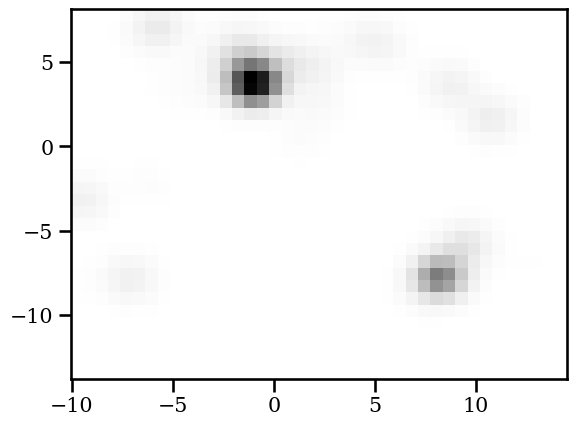

In [81]:
plot_kde_cover(marginal_1.to_numpy()[:,:2], cmap="Greys");

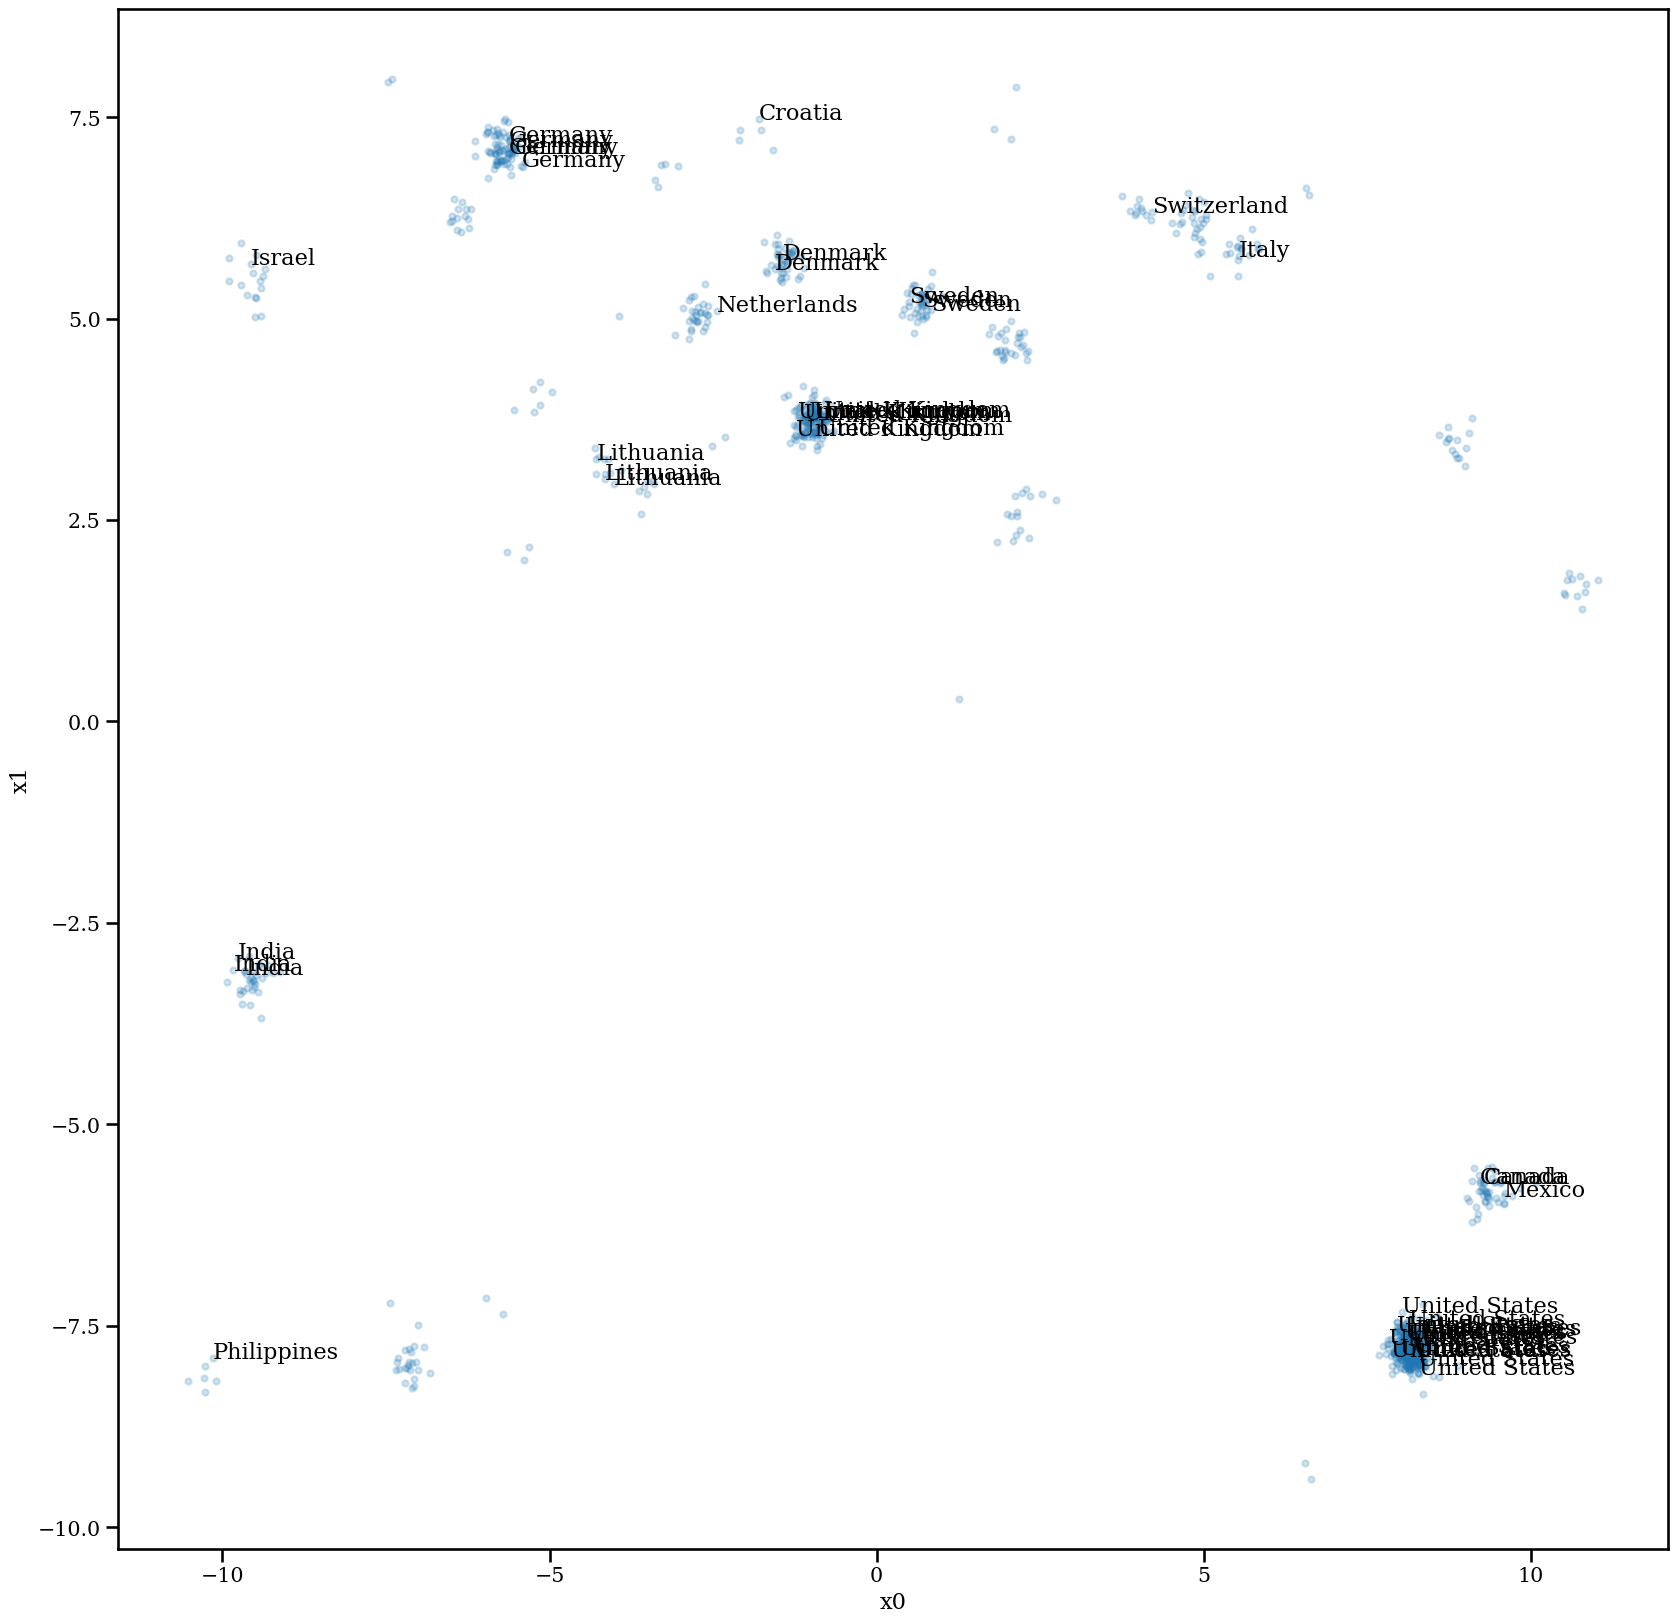

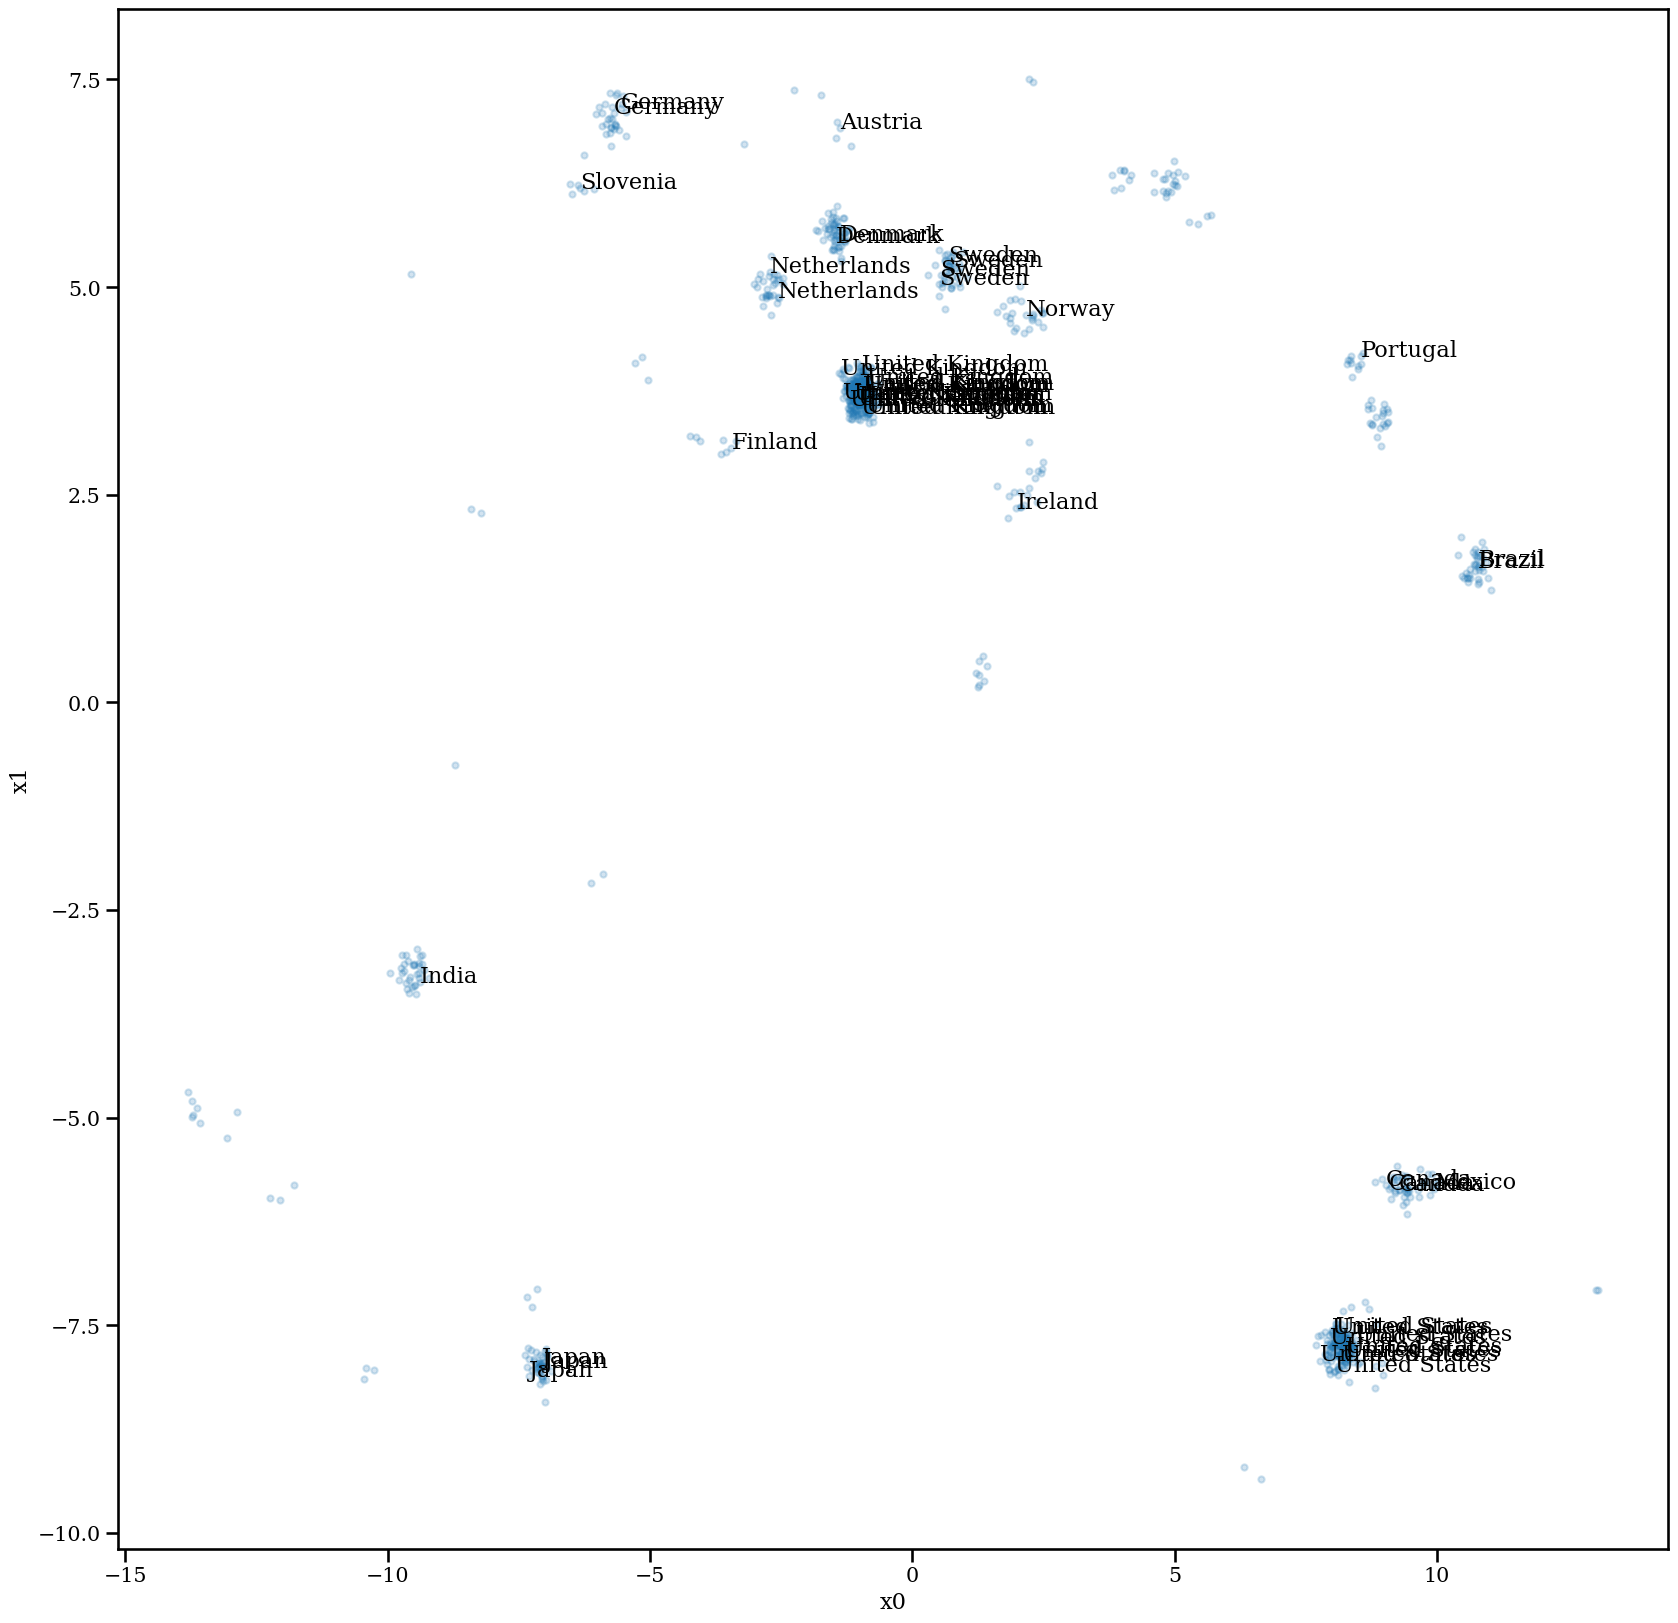

In [82]:
plot_marginal(marginal_0, alpha=.2)
plot_marginal(marginal_1, alpha=.2)

In [83]:
# Sample antigen embeddings from variant mixes

def variant_mix_to_embs(marginal):
    # Sample variant
    variants_rand_sampling = np.random.uniform(size=marginal.shape[0])
    variants_intervals = np.cumsum(marginal.loc[:,variants_of_interest].to_numpy(), axis=1)

    variants_selected_idxs = (variants_intervals <= np.expand_dims(variants_rand_sampling, axis=1)).sum(axis=1)

    ordered_variants_of_interest = np.concatenate([raw_variants_antigen_embs[var_name] for var_name in marginal.columns[2:]], axis=0)

    embs_selected = ordered_variants_of_interest[variants_selected_idxs]

    return np.concatenate([marginal.loc[:,['x0', 'x1']].to_numpy(), embs_selected], axis=1)

In [84]:
marginal_0.loc[:,["Alpha", "Beta", "Delta", "Gamma", "others"]]

,Alpha,Beta,Delta,Gamma,others
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
Argentina,0.1633,0.0000,0.0000,0.2296,0.6071
...,...,...,...,...,...
United States,0.5185,0.0075,0.0006,0.0302,0.4432
United States,0.5185,0.0075,0.0006,0.0302,0.4432
United States,0.5185,0.0075,0.0006,0.0302,0.4432
United States,0.5185,0.0075,0.0006,0.0302,0.4432


<Axes: >

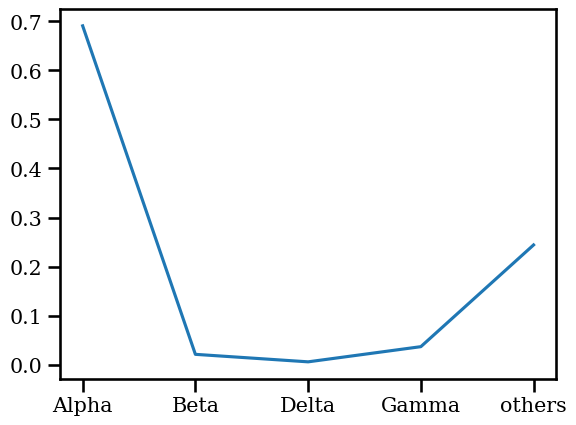

In [85]:
marginal_0.loc[:,["Alpha", "Beta", "Delta", "Gamma", "others"]].mean().plot()

In [86]:
unscaled_t0_embs = variant_mix_to_embs(marginal_0)
unscaled_t1_embs = variant_mix_to_embs(marginal_1)

In [87]:
def adjust_antigen_variances(marginal_0, marginal_1, antigen_store):

    empirical_stds = np.concatenate([marginal_0[:,2:], marginal_1[:,2:]], axis=0).std(axis=0)

    marginal_0[:,2:] *= common_variance_increased_fact / empirical_stds
    marginal_1[:,2:] *= common_variance_increased_fact / empirical_stds

    scaled_store = {}
    for ag_name in antigen_store:
        scaled_store[ag_name] = antigen_store[ag_name] * common_variance_increased_fact / empirical_stds

    return marginal_0, marginal_1, scaled_store

In [88]:
t0_embs, t1_embs, variants_antigen_embs = adjust_antigen_variances(unscaled_t0_embs, unscaled_t1_embs, raw_variants_antigen_embs)

In [89]:
t0_embs.mean(axis=0), t0_embs.std(axis=0)

(array([ 2.51972473, -0.75906558,  5.52927682, -2.89983065, -1.40679673,
        -0.41951542]),
 array([6.01532132, 6.2647651 , 2.68217631, 6.87785899, 8.8549024 ,
        5.36703617]))

In [90]:
t1_embs.mean(axis=0), t1_embs.std(axis=0)

(array([ 1.47653543,  0.51172866, -6.08215032,  4.6304043 ,  3.67627486,
        -9.99059302]),
 array([ 5.91789733,  5.44686737, 12.98080507, 12.29746128, 10.9257227 ,
        12.6450146 ]))

In [91]:
t1_embs.std(axis=0)/t0_embs.std(axis=0)

array([0.98380403, 0.86944479, 4.83965391, 1.78797811, 1.23386145,
       2.35605168])

In [92]:
sequences_in_window = period_cov_variants.query("variant in @variants_of_interest").query("@t0 <= date and date <= @t1")
variants_evo_by_country = sequences_in_window[['location', 'variant', 'date']].join(sequences_in_window.apply(lambda r: r['num_sequences']/r['num_sequences_total'], axis=1).to_frame().rename({0: 'perc_sequences'}, axis=1)).set_index(['location', 'variant', 'date']).unstack(1)

sequences_evo_by_country = period_cov_variants.query("variant in @variants_of_interest").query("@t0 <= date and date <= @t1").groupby(["location", "date"]).agg({'num_sequences_total': 'first'})

In [93]:
# Save marginals & scaled embeddings
sb_dataset_name = "covid_v4"

np.save(f"covid/{sb_dataset_name}_t0_points.npy", t0_embs)
np.save(f"covid/{sb_dataset_name}_t1_points.npy", t1_embs)

np.savez(f"covid/{sb_dataset_name}_antigen_embs.npz", **variants_antigen_embs)

scaled_country_embs.to_csv(f"covid/{sb_dataset_name}_country_embs.csv")

pd.Series(marginal_0.columns[2:]).to_csv(f"covid/{sb_dataset_name}_variant_names.csv")

In [94]:
# Save additional info for visualization purposes
variants_evo_by_country.droplevel(0, axis=1).to_csv(f"covid/{sb_dataset_name}_evolution_ground_truth.csv")
sequences_evo_by_country.to_csv(f"covid/{sb_dataset_name}_tot_sequences_ground_truth.csv")

In [14]:
import joblib
joblib.dump(antigen_pca, f"covid/{sb_dataset_name}_antigen_pca.joblib")

['covid/covid_v4_antigen_pca.joblib']

In [95]:
sequences_evo_by_country

num_sequences_total
location date                           
Angola   2021-04-05                  137
         2021-04-19                   83
         2021-05-03                   34
         2021-05-17                    5
         2021-05-31                    7
...                                  ...
Zambia   2021-04-05                    9
         2021-04-19                    2
         2021-05-03                   18
         2021-05-31                   87
         2021-06-14                   94

[646 rows x 1 columns]

In [96]:
variants_evo_by_country

perc_sequences                                        
variant                      Alpha      Beta     Delta     Gamma    others
location date                                                             
Angola   2021-04-05       0.233577  0.467153  0.000000  0.007299  0.204380
         2021-04-19       0.253012  0.373494  0.024096  0.000000  0.313253
         2021-05-03       0.323529  0.500000  0.029412  0.000000  0.147059
         2021-05-17       0.000000  0.000000  0.800000  0.000000  0.200000
         2021-05-31       1.000000  0.000000  0.000000  0.000000  0.000000
...                            ...       ...       ...       ...       ...
Zambia   2021-04-05       0.111111  0.777778  0.111111  0.000000  0.000000
         2021-04-19       0.000000  0.500000  0.000000  0.000000  0.500000
         2021-05-03       0.000000  0.666667  0.000000  0.000000  0.166667
         2021-05-31       0.000000  0.000000  1.000000  0.000000  0.000000
         2021-06-14       0.010638  0.010638  0.978723  0.000000  0.000000

[646 rows x 5 columns]

In [ ]:
variants_evo_by_country.loc["Italy"].plot();
export_fig("usb_covid_variant_mix_italy_ground_truth")
variants_evo_by_country.loc["United States"].plot();
export_fig("usb_covid_variant_mix_us_ground_truth")
variants_evo_by_country.loc["India"].plot();
export_fig("usb_covid_variant_mix_india_ground_truth")

In [98]:
# variants_evo_by_country.droplevel(0).groupby("date").agg('mean').plot()

In [99]:
restricted_period_cases = period_cov_variants.query("variant in @variants_of_interest").query("@t0 <= date and date <= @t1")
restricted_period_cases

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
336,Angola,2021-04-05,Alpha,32,23.36,137
346,Angola,2021-04-05,Beta,64,46.72,137
347,Angola,2021-04-05,Delta,0,0.00,137
350,Angola,2021-04-05,Gamma,1,0.73,137
358,Angola,2021-04-05,others,28,20.43,137
...,...,...,...,...,...,...
99504,Zambia,2021-06-14,Alpha,1,1.06,94
99514,Zambia,2021-06-14,Beta,1,1.06,94
99515,Zambia,2021-06-14,Delta,92,97.87,94
99518,Zambia,2021-06-14,Gamma,0,0.00,94


In [ ]:
# Directly count sequences

variant_for_baseline = "Delta"
restricted_period_cases.query(f"variant == 'Alpha'").groupby('date').agg({'num_sequences': 'sum', 'num_sequences_total': 'sum'}).apply(lambda r: round(r['num_sequences']/r['num_sequences_total'], 2), axis=1).plot()
restricted_period_cases.query(f"variant == 'Beta'").groupby('date').agg({'num_sequences': 'sum', 'num_sequences_total': 'sum'}).apply(lambda r: r['num_sequences']/r['num_sequences_total'], axis=1).plot()
restricted_period_cases.query(f"variant == 'Delta'").groupby('date').agg({'num_sequences': 'sum', 'num_sequences_total': 'sum'}).apply(lambda r: r['num_sequences']/r['num_sequences_total'], axis=1).plot()
restricted_period_cases.query(f"variant == 'Gamma'").groupby('date').agg({'num_sequences': 'sum', 'num_sequences_total': 'sum'}).apply(lambda r: r['num_sequences']/r['num_sequences_total'], axis=1).plot()
restricted_period_cases.query(f"variant == 'others'").groupby('date').agg({'num_sequences': 'sum', 'num_sequences_total': 'sum'}).apply(lambda r: r['num_sequences']/r['num_sequences_total'], axis=1).plot()

export_fig("usb_covid_variant_mix_evo_ground_truth")

### Save data for baseline

Daily CoVid cases by **Our World in Data**, reference:

    @article{owidcoronavirus,
        author = {Edouard Mathieu and Hannah Ritchie and Lucas Rodés-Guirao and Cameron Appel and Charlie Giattino and Joe Hasell and Bobbie Macdonald and Saloni Dattani and Diana Beltekian and Esteban Ortiz-Ospina and Max Roser},
        title = {Coronavirus Pandemic (COVID-19)},
        journal = {Our World in Data},
        year = {2020},
        note = {https://ourworldindata.org/coronavirus}
    }

In [ ]:
variants_evo_by_country.droplevel(0).groupby("date").agg('mean').plot()

In [102]:
tmp_good_mix = variants_evo_by_country.droplevel(0, axis=1).copy()
tmp_good_mix['others'] = tmp_good_mix['others'] + (1 - tmp_good_mix.sum(axis=1))

In [ ]:
tmp_good_mix.groupby("date").agg('mean').plot()

In [104]:
sequences_evo_by_country.max()

num_sequences_total    80542
dtype: int64

In [105]:
sir_variant = "Delta"
sir_input = variants_evo_by_country.swaplevel(0,1).droplevel(0, axis=1)[sir_variant].groupby('date').mean() * sequences_evo_by_country.groupby('date').agg('sum')['num_sequences_total']
sir_input = sir_input.apply(lambda x: int(x)).to_frame()
sir_input = sir_input.rename({0: 'daily_confirm'}, axis=1)
sir_input

,daily_confirm
date,
2021-04-05,3086
2021-04-19,13882
2021-05-03,19071
2021-05-17,24037
2021-05-31,26695
2021-06-14,38060
